Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.

This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.


In [6]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

## 0. Parameters

In [2]:
per_user_supply_const = 5
dict_notification = {
    'comment_subscribed': 4285.714285714285,
    'feed_suite_organic_campaign': 149994.99857142856,
    'like': 123731.63142857143,
    'story_daily_digest': 190625.00142857147
}

## 1. Load Dataset

**This data file is outputted by the notebook `[notification_auction] simulation.ipynb`**

In [3]:
df_simulation = pd.read_csv('simulation_outcome.csv')

## 2. Pacing Multiplier Plotting and Standard Deviation Computation


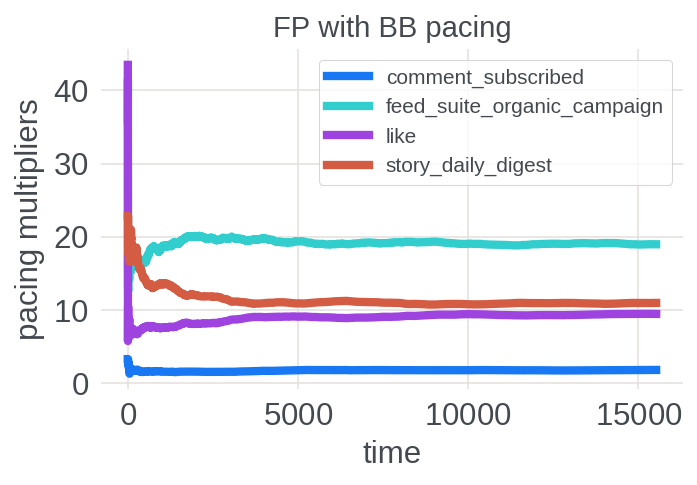

In [7]:
df_simulation['minute bucket'] = np.round(df_simulation['auction_event_time'] / 60.0)
df_simulation_minute_bucketed = df_simulation.groupby(
    ['minute bucket', 'notification_type']
).agg(
    {'notif_type_pacing_multiplier': 'mean'}
).reset_index()

plt.subplots(figsize=(5,3), dpi=150)
for notification_type, _ in dict_notification.items():
    selector = df_simulation_minute_bucketed['notification_type']==notification_type
    plt.plot(
        df_simulation_minute_bucketed.index[selector],
        df_simulation_minute_bucketed.notif_type_pacing_multiplier[selector],
        label=notification_type
    )

plt.legend(loc='upper right')
plt.xlabel('time')
plt.ylabel('pacing multipliers')
plt.title('FP with BB pacing', fontsize=14);

In [9]:
df_simulation_minute_bucketed.groupby('notification_type').agg({
    'notif_type_pacing_multiplier': 'std'
})

,notif_type_pacing_multiplier
notification_type,
comment_subscribed,0.106921
feed_suite_organic_campaign,0.797137
like,0.796410
story_daily_digest,1.274550


## 3. All Other Metrics

In [13]:
def calc_auction_metrics_v2(auction_sim_data, budget_dict, per_user_supply_const):

    # The input table auction_sim_data should have the following columns:     
    # 1. event_id 
    # 2. user_id 
    # 3. auction_event_date
    # 4. auction_event_time
    # 5. sim_notif_win
    # 6. notification_value
    # 7. notification_type
    # 8. notif_type_pacing_multiplier
    # 9. platform_pacing_multiplier

    # budget_dict is a dictionary with the notification type as key and corresponding budget as the values
    # per_user_supply_const is an integer specifying the supply constraint at a user level

    auction_metrics = {}
    auction_metrics['avg_winning_bid'] = calc_avg_winning_val(auction_sim_data, metric_type = 'notification_value')
    auction_metrics['per_type_utility'] = calc_utility_per_type(auction_sim_data)
    auction_metrics['budget_wt_gm_utility'] = calc_EG_obj(auction_metrics['per_type_utility'], budget_dict) 
    auction_metrics['supply_const_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 1, 'supply_const_violation')
    auction_metrics['supply_const_1.25_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 1.25, 'supply_const_violation')
    auction_metrics['supply_const_1.5_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 1.5, 'supply_const_violation')
    auction_metrics['supply_const_2_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 2, 'supply_const_violation')
    auction_metrics['supply_const_2.25_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 2.25, 'supply_const_violation')
    auction_metrics['supply_const_2.5_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 2.5, 'supply_const_violation')
    auction_metrics['supply_const_5_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 5, 'supply_const_violation')
    auction_metrics['supply_const_10_violation_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 10, 'supply_const_violation')
    auction_metrics['num_sent_notifs']= calc_num_sent_notifs(auction_sim_data)
    auction_metrics['avg_violation_per_user'] = calc_avg_violation_wastage_per_user(auction_sim_data, per_user_supply_const, 'supply_const_violation')
    auction_metrics['wastage_rate'] = calc_supply_const_violation_wastage_rate(auction_sim_data, per_user_supply_const, 1, 'wastage')
    auction_metrics['wastage_per_user'] = calc_avg_violation_wastage_per_user(auction_sim_data, per_user_supply_const, 'wastage')
    return auction_metrics


def calc_avg_winning_val(auction_sim_data: pd.DataFrame, metric_type = 'notification_value') -> float:
    winning_notifs = auction_sim_data.loc[auction_sim_data['sim_notif_win']==1]
    avg_winning_val = np.mean(winning_notifs[metric_type].values)
    return avg_winning_val

def calc_utility_per_type(auction_sim_data: pd.DataFrame):
    winning_notifs = auction_sim_data.loc[auction_sim_data['sim_notif_win']==1]
    per_type_utility = winning_notifs.groupby(['notification_type'])['notification_value'].sum()
    return per_type_utility.to_dict()

def calc_EG_obj(utility_dict, budget_dict):
    assert(set(utility_dict.keys()) == set(budget_dict.keys()))
    num_notif_types = len(utility_dict.keys())
    utilities = np.zeros(num_notif_types)
    budgets = np.zeros(num_notif_types)
    for i, notif_type in enumerate(utility_dict.keys()):
        utilities[i] = utility_dict[notif_type]
        budgets[i] = budget_dict[notif_type]
    return np.sum(np.log(utilities) * budgets)

# metric_type should either be 'supply_const_violation' or 'wastage'
def calc_supply_const_violation_wastage_rate(auction_sim_data: pd.DataFrame, per_user_supply_const:int, supply_factor=1.0, metric_type='supply_const_violation') -> float:
    num_gen_notifs_per_user = auction_sim_data.groupby(['user_id'])['event_id'].size().rename('num_notif_gen').reset_index()
    winning_notifs = auction_sim_data.loc[auction_sim_data['sim_notif_win']==1]
    num_winning_notifs_per_user = winning_notifs.groupby(['user_id'])['sim_notif_win'].sum().rename('num_notif_win').reset_index().merge(
        num_gen_notifs_per_user, how='right', on='user_id'
    )
    if metric_type=='supply_const_violation':
        num_winning_notifs_per_user['user_metric'] = num_winning_notifs_per_user['num_notif_win'] > supply_factor*per_user_supply_const
    elif metric_type =='wastage':
        num_winning_notifs_per_user['user_metric'] = num_winning_notifs_per_user['num_notif_win'] < np.minimum(per_user_supply_const, num_winning_notifs_per_user['num_notif_gen'])
    return np.mean(num_winning_notifs_per_user['user_metric'].values)

def calc_num_sent_notifs(auction_sim_data: pd.DataFrame):
    winning_notifs = auction_sim_data.loc[auction_sim_data['sim_notif_win']==1]
    num_winning_notifs_dict = winning_notifs.groupby(['notification_type'])['event_id'].count().to_dict()
    num_winning_notifs_dict['all'] = len(winning_notifs)
    return num_winning_notifs_dict

# metric_type should either be 'supply_const_violation' or 'wastage'
def calc_avg_violation_wastage_per_user(auction_sim_data: pd.DataFrame, per_user_supply_const:int, metric_type='supply_const_violation') -> float:
    winning_notifs = auction_sim_data.loc[auction_sim_data['sim_notif_win']==1]
    num_winning_notifs_per_user = winning_notifs.groupby(['user_id'])['sim_notif_win'].sum().rename('num_notif_win').reset_index()
    num_gen_notifs_per_user = auction_sim_data.groupby(['user_id'])['event_id'].size().rename('num_notif_gen').reset_index()
    joint_df = num_winning_notifs_per_user.merge(num_gen_notifs_per_user, on='user_id', how='left')
    if metric_type=='supply_const_violation':
        num_winning_notifs_per_user['user_metric'] = np.maximum(num_winning_notifs_per_user['num_notif_win'] - per_user_supply_const, 0)
    elif metric_type =='wastage':
        num_winning_notifs_per_user['user_metric'] = np.maximum(np.minimum(per_user_supply_const, joint_df['num_notif_gen'])  - joint_df['num_notif_win'] , 0)
    return np.mean(num_winning_notifs_per_user['user_metric'].values)


In [16]:
metrics = calc_auction_metrics_v2(df_simulation, dict_notification, per_user_supply_const)
metrics

{'avg_winning_bid': 0.590813865874112,
 'per_type_utility': {'comment_subscribed': 2379.3031765791843,
  'feed_suite_organic_campaign': 7908.0228164380605,
  'like': 13088.731217890978,
  'story_daily_digest': 17400.73418399124},
 'budget_wt_gm_utility': 4413848.022289559,
 'supply_const_violation_rate': 0.07934398845905623,
 'supply_const_1.25_violation_rate': 0.049998101818457916,
 'supply_const_1.5_violation_rate': 0.03583766751452109,
 'supply_const_2_violation_rate': 0.012565961808587373,
 'supply_const_2.25_violation_rate': 0.008351998785163814,
 'supply_const_2.5_violation_rate': 0.00523898105614821,
 'supply_const_5_violation_rate': 0.0,
 'supply_const_10_violation_rate': 0.0,
 'num_sent_notifs': {'comment_subscribed': 4307,
  'feed_suite_organic_campaign': 14401,
  'like': 20107,
  'story_daily_digest': 30203,
  'all': 69018},
 'avg_violation_per_user': 0.24618878965198646,
 'wastage_rate': 0.027561595991040584,
 'wastage_per_user': 0.04919926085617493}